## Digit Recognition by Clustering

According to the given information, the data reflects 16 x 16 grayscale images of digits. 
Each line is organized by a corresponding id (0-9) followed by the 256 grayscale values.
   <br />             
We begin with 7291 training observations with the following distribution:
<br />
<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;7&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9&nbsp;&nbsp;&nbsp;&nbsp;Total**
<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Instances**&nbsp;&nbsp;1194&nbsp;&nbsp;1005&nbsp;&nbsp;&nbsp;731&nbsp;&nbsp;658&nbsp;&nbsp;652&nbsp;&nbsp;556&nbsp;&nbsp;664&nbsp;&nbsp;645&nbsp;&nbsp;542&nbsp;&nbsp;644&nbsp;&nbsp;7291
<br />
**as proportions** &nbsp;0.16&nbsp;&nbsp;0.14&nbsp;&nbsp;&nbsp;0.1&nbsp;&nbsp;0.09&nbsp;0.09&nbsp;0.08&nbsp;0.09&nbsp;0.09&nbsp;0.07&nbsp;0.09
<br /><br />
We start by importing packages, reading the data, and removing all rows which do not contain numbers.
<br />

In [1]:
#Do we need all of these?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as plot
from sklearn import mixture
from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
import sklearn.datasets
import seaborn as sns; sns.set()

#Can we take this out????
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
training_data = pd.read_csv("data/zip.train", header=None , sep=" ")
training_data = training_data.dropna(axis=1, how='any',thresh=None)


## Digit as object##
After creating multiple functions, and multiple headaches, it became clear that creating a Class would be a good idea to manipulate, organize, and visualize the data more efficiently.  <br /> Ten digits, ten objects. 

In [3]:
class Digit :
    def __init__(self,digit,data) :  
        self.digit = digit   # Digit (0-9)
        self.data = data     # Training data
    
    def is_num(self) :
        return pd.DataFrame(self.data[self.data[0]==self.digit])

    def only_num(self) :
        return pd.DataFrame((self.is_num()).drop((self.is_num()).columns[[0]],axis=1))
    
    def get_cluster_count (self,df) :
        cluster_count = pd.DataFrame((df[df[0]==self.digit])['Label'].value_counts())
        cluster_count.rename(columns={'Label':'Count'}, inplace=True)
        return cluster_count
    
    def get_cluster_percent(self,df):
        percent_list = []
        cluster_percent = self.get_cluster_count(df) 
        i = 0
        while i < len(cluster_percent) :
            percent_list.append(float((cluster_percent.iloc[i])/(cluster_percent.sum()))*100)
            i += 1
        cluster_percent['Percent'] = (percent_list)
        return cluster_percent.drop('Count',1)    
    
    def get_predicted_cluster(self,df):
        return (self.get_cluster_count(df)).index[0]
  

**Create 10 digit objects**

In [4]:
zero  = Digit(0,training_data)
one   = Digit(1,training_data) 
two   = Digit(2,training_data)
three = Digit(3,training_data)
four  = Digit(4,training_data)
five  = Digit(5,training_data)
six   = Digit(6,training_data)
seven = Digit(7,training_data)
eight = Digit(8,training_data)
nine  = Digit(9,training_data)

all_digits= [zero,one,two,three,four,five,six,seven,eight,nine]


**Additional functions for use with more than one digit**

In [5]:
def get_cluster_name(df) :
        cluster_name = df[[0,'Label']]
        cluster_name.columns = ['Digit','Cluster']
        return cluster_name

def get_all_clusters (df):
    all_clusters = []
    for digit in all_digits :
        all_clusters.append(digit.get_predicted_cluster(df))
    return np.array(all_clusters)

def plot_bar (df):
    result_for_bar = pd.concat([zero.get_cluster_percent(df),one.get_cluster_percent(df),two.get_cluster_percent(df),three.get_cluster_percent(df),four.get_cluster_percent(df),five.get_cluster_percent(df),six.get_cluster_percent(df),seven.get_cluster_percent(df),eight.get_cluster_percent(df),nine.get_cluster_percent(df)],axis=1, sort=False)
    result_for_bar = result_for_bar.fillna(0)
    result_for_bar_T = result_for_bar.T
    result_for_bar_T =result_for_bar_T.rename(index=str, columns={0: "a", 1: "b", 2: "c", 3: "d", 4: "e", 5: "f", 6: "g", 7: "h", 8: "i", 9: "j"})    
    result_for_bar_T.loc[:,:].plot.bar(stacked=True,color=sns.color_palette("hls", 10), figsize=(15,7))
    
    
    # change the size of legend
    params = {'legend.fontsize': 20,
              'legend.handlelength': 2}
    plot.rcParams.update(params)

    #change legend position
    ax = plt.gca()
    labels = ("0","1","2","3","4","5","6","7","8","9")
    ax.set_xticklabels(labels, fontsize=18)
    plt.xlabel('digit', fontsize=18)
    plt.ylabel('% cluster per digit', fontsize=18)
    #ax = plt.gca()
    plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes, title = "cluster")
    
def get_all_correct_clusters (df):
    frequency = get_all_clusters(df) 
    label_digit_assignment = get_cluster_name(df)
    label_digit_assignment.rename(columns={1: 'Cluster'})
    df_supposed_cluster = pd.DataFrame(label_digit_assignment["Digit"].replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], frequency))
    df_supposed_cluster.columns = ['Correct']
    digit_supposed_cluster = pd.concat([label_digit_assignment, df_supposed_cluster], axis=1)
    return digit_supposed_cluster

def get_accuracy(df) :
    a = get_all_correct_clusters(df)['Cluster']
    b = get_all_correct_clusters(df)['Correct']
    acc = accuracy_score(a,b, normalize=False)
    acc_normalized= accuracy_score(a, b, normalize=True)
    return str(acc) + " ; " + str(acc_normalized)

## Clustering the data
 <br /> Initial approach: k-means clustering  <br />
 Also considered: Gaussian Mixture Model clustering 

In [6]:
data_with_digit = training_data.copy() #For confusion matrix 

data_with_digit_kmeans = training_data.copy()
data_without_digit_kmeans = data_with_digit_kmeans.iloc[:,1:]

data_with_digit_gmm = training_data.copy()
data_without_digit_gmm = data_with_digit_gmm.iloc[:,1:]

data_with_digit_transform = training_data.copy()
data_without_digit_transform = data_with_digit_transform.iloc[:,1:]
data_without_digit_transform = data_without_digit_transform**2


# Initialize k-means model
np.random.seed(0)
kmeans = KMeans(10,random_state=0) 
labels = kmeans.fit(data_without_digit_kmeans).predict(data_without_digit_kmeans)
data_with_digit_kmeans['Label'] = labels

# Initialize k-means model with data transformation
np.random.seed(0)
kmeans_transform = KMeans(10,random_state=0) 
labels_transform = kmeans_transform.fit(data_without_digit_transform).predict(data_without_digit_transform)
data_with_digit_transform['Label'] = labels_transform

# Initialize Gaussian Mixture Model
# To be honest, I really don't get this model
np.random.seed(0)
gmm = GMM(n_components=10,random_state=0).fit(data_without_digit_gmm)
labels_gmm = gmm.predict(data_without_digit_gmm)
data_with_digit_gmm['Label'] = labels_gmm


**Naming the clusted data for later use in functions**

In [7]:
k_means_output = data_with_digit_kmeans
gmm_output = data_with_digit_gmm
k_means_output_transform = data_with_digit_transform

## First Impressions

What are the clusters "named?"<br /> To how many clusters are observations of a single digit assigned?<br /> How do the models compare?

In [8]:
three.get_cluster_count(gmm_output)


,Count
9,296
4,165
0,95
8,44
6,42
1,12
7,3
3,1


In [9]:
one.get_cluster_count(k_means_output)

,Count
2,1001
9,3
7,1


In [10]:
one.get_cluster_count(gmm_output)

,Count
2,951
0,45
7,7
6,2


In [11]:
three.get_cluster_percent(k_means_output)

,Percent
4,82.826748
9,11.094225
6,1.975684
7,1.671733
1,1.215805
5,0.303951
3,0.303951
0,0.303951
8,0.151976
2,0.151976


In [12]:
three.get_cluster_percent(gmm_output)

,Percent
9,44.984802
4,25.075988
0,14.437690
8,6.686930
6,6.382979
1,1.823708
7,0.455927
3,0.151976


## Clusters and Digits
<br/>**Evaluating k-means clustering**<br/>

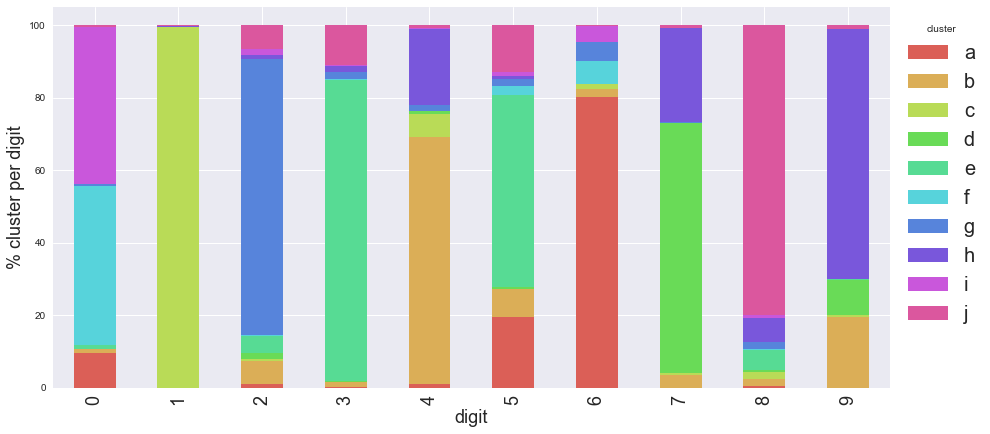

In [13]:
plot_bar(k_means_output)

<br />**Evaluating Gaussian Mixture Model clustering**<br />

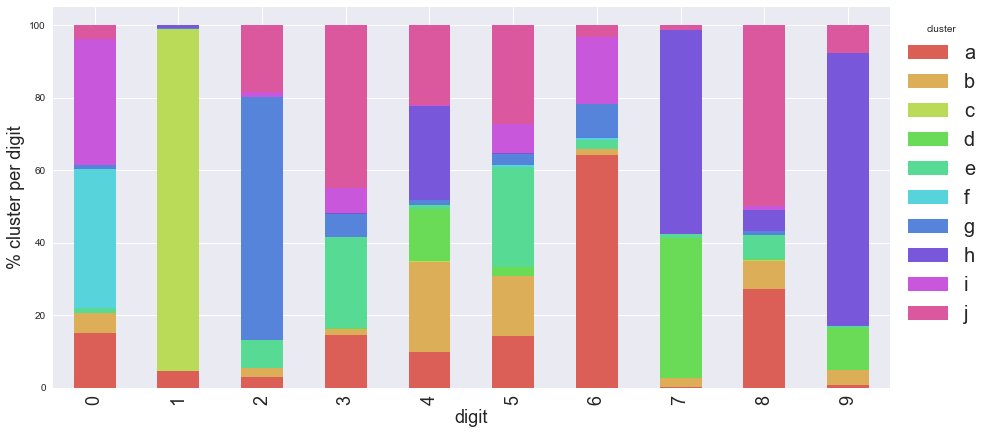

In [14]:
plot_bar(gmm_output)

## Further questions
<br />To which cluster is a digit predicted?<br />Are there any overlaps?

**With k-means (3 and 5)**

In [15]:
get_all_clusters(k_means_output)

array([5, 2, 6, 4, 1, 4, 0, 3, 9, 7])

In [16]:
three.get_predicted_cluster(k_means_output)

4

In [17]:
five.get_predicted_cluster(k_means_output)

4

**With Gaussian Mixture Model (three, four, seven, eight, and nine)**

In [18]:
get_all_clusters(gmm_output)    

array([5, 2, 6, 9, 7, 4, 0, 7, 9, 7])

In [19]:
four.get_predicted_cluster(gmm_output)

7

In [20]:
nine.get_predicted_cluster(gmm_output)

7

## Looking at the big picture

With regard to the type of clustering, how often do digits need to be reassigned?<br/> (Or rather, how many instances in our data are "incorrectly" clustered based on the assumption that the majority cluster is the correct cluster for that digit.)

In [21]:
get_all_correct_clusters(k_means_output).head()

,Digit,Cluster,Correct
0,6.0,0,0.0
1,5.0,4,4.0
2,4.0,1,1.0
3,7.0,3,3.0
4,3.0,4,4.0


In [22]:
get_all_clusters(k_means_output)

array([5, 2, 6, 4, 1, 4, 0, 3, 9, 7])

## Calculating the accuracy for all (7291) observations

In [23]:
get_accuracy(k_means_output)

'5222 ; 0.7162254834727747'

In [24]:
get_accuracy(gmm_output)

'4060 ; 0.5568509120833904'

## Confusion Matrix

In [25]:
bar_data =pd.DataFrame(np.zeros((10,10)))

for digit in range(0,10):
    dwd = data_with_digit_kmeans[data_with_digit_kmeans[0] == digit].groupby('Label').count()[0]
    cluster_keys = dwd.keys()
    for cluster_idx in cluster_keys:
        bar_data[digit][cluster_idx] = dwd[cluster_idx]
        
# Percentage of cluster assignment
bar_data1 = pd.DataFrame(bar_data)

bar_data1.columns=['a','b','c','d','e','f','g','h','i','j']

rel_den = pd.DataFrame(np.zeros((10,10)))

for j in range(0,10):
    for i in range(0,10):
        rel_den.iloc[i,j] = bar_data1.iloc[i,j]/bar_data1.iloc[i].sum()*100

rel_den.columns=['a','b','c','d','e','f','g','h','i','j']
rel_den

,a,b,c,d,e,f,g,h,i,j
0,14.838710,0.000000,0.903226,0.258065,0.774194,14.064516,68.774194,0.000000,0.387097,0.000000
1,1.517241,0.000000,6.482759,1.103448,61.379310,5.793103,1.931034,3.172414,1.379310,17.241379
2,0.000000,93.202980,0.279330,0.093110,3.817505,0.000000,0.837989,0.279330,1.024209,0.465549
3,0.000000,0.000000,2.448211,0.376648,0.941620,0.564972,0.000000,83.804143,0.376648,11.487759
4,1.628664,0.000000,3.691640,59.174810,0.000000,32.030402,0.000000,0.000000,3.257329,0.217155
5,89.115646,0.000000,0.510204,0.340136,0.000000,2.380952,7.312925,0.000000,0.340136,0.000000
6,0.933126,0.000000,86.469673,2.021773,1.866252,1.555210,5.287714,0.311042,1.555210,0.000000
7,0.000000,0.123153,1.108374,1.354680,16.871921,0.615764,0.123153,20.689655,4.433498,54.679803
8,90.685413,0.000000,2.108963,0.175747,0.175747,1.230228,4.920914,0.000000,0.702988,0.000000
9,1.071975,0.459418,7.197550,11.179173,0.765697,10.872894,0.306279,0.612557,66.462481,1.071975


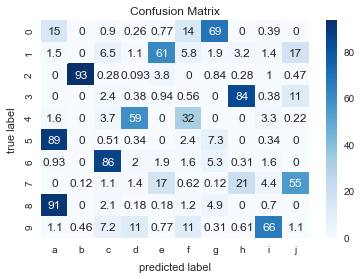

In [26]:
ax = sns.heatmap(rel_den, annot=True, annot_kws={"size": 12}, cmap="Blues")
ax.set_xlabel('predicted label', labelpad=8)
ax.set_ylabel('true label', labelpad=8)
ax.set_title('Confusion Matrix');
plt.show()

In [27]:
one.get_predicted_cluster(k_means_output)

2

In [28]:
get_all_clusters(k_means_output)

array([5, 2, 6, 4, 1, 4, 0, 3, 9, 7])